# Aşırı Uydurma ve Erken Durdurma
Overfitting and Early Stopping


---


### Basit Bir Öğrenme Modelinde Aşırı Uydurma (Overfitting) Probleminin Çözümü: Erken Durdurma (Early Stopping)

---

Bunun için iki sınıflı rastgele değerlere sahip bir veri seti için basit bir çok katmanlı sinir ağı (Multi Layer Perceoptron) oluşturulmuştur. 

* Aktivasyon fonksiyonu olarak **ReLU** ve çıkış katmanında **Sigmoid** kullanılmıştır. Aktivasypn fonksiyonlarıyla ilgili daha kapsamlı bilgi için [**buraya**](https://github.com/ayyucekizrak/Udemy_DerinOgrenmeyeGiris/tree/master/Aktivasyon_Fonksiyonlarinin_Karsilastirilmasi) tıklayınız!

* Hatayı minimize etmek için **Adam** optimizasyon algoritması kullanılmıştır. Optimizasyon algoritmaları hakkında daha kapsamlı bilgi için [**buraya**](https://github.com/ayyucekizrak/Udemy_DerinOgrenmeyeGiris/tree/master/Optimizasyon_Algoritmalarinin_Karsilastirilmasi) tıklayınız!

* Tüm eğitim işlemi sonunda en iyi sonucun elde edildiği **epoch**'ta kaydedilen model ağırlıkları en iyi model ağırlıkları olarak **ModelCheckPoints** ile kaydedilmiştir.

Hadi birlikte işlemleri nasıl yapmamız gerektiğine adım adım bakalım.


---

[Aynı çalışmanın MNIST veri seti örneğinde basit bir evrişimli sinir ağı modeli için hazırlanmış versiyonuna buradan ulaşabilirsiniz!](https://github.com/ayyucekizrak/Udemy_DerinOgrenmeyeGiris/blob/master/Asiri_Uydurma_Overfitting_ve_Erken_Durdurma_Early_Stopping/AsiriUydurma_Overfitting_v2.ipynb)

---

# Aşırı Uydurma (Overfitting) Nedir?

Tasarladığımız modele verilerimizi öğretmek için ve test etmek için iki parça halinde besleriz. Bazen öyle bir an gelir ki eğitim için ayırdığımız sette sürekli öğrenme hatası düşer ve biz de bu durumdan oldukça memnun bir şekilde test aşamasına geçeriz. Modelimizin hesapladığı öğrenilmiş ağırlıklar ile daha önce karşılaşmadığı test kümesi ile modeli beslediğimizde karşılaştığımız şey hüsran olabilir. Bu olayla karşılaşmanın bir çok sebebi olabilir ve sebeplere göre uygun çözümü bulmamız gerekir.

[![image](https://i.hizliresim.com/5avYZR.png)](https://hizliresim.com/5avYZR)

* Dengesiz veri kümesi dağılımı problemi olabilir
* Eğitim, Geçerleme/Doğrulama ve Test kümelerimizi uygun şekilme bölmemiş olabiliriz
* Epoch sayısı fazla seçilmiş olabilir
* Eğitim kümemiz yanlı (bias) olabilir
* Modelimiz gereğinden fazla karmaşık olabilir

Tüm bunlar **aşırı uydurma** ya da **ezberleme** dediğimiz sorunu ortaya çıkarıyor olabilir. Özetle buna **BİAS**- **VARYANS** dengesi diyoruz.

Modelimiz ne az ne çok karmaşık olmalı, yeterinde eğitilmiş olmalı, veri kümesi dağılımını doğru yapmalı ve gerçek hayatı temsil eder karmaşıklıkta olmalı.

[![image](https://i.hizliresim.com/Bad8qg.png)](https://hizliresim.com/Bad8qg)

### Çözüm: Erken Durdurma (Early Stopping)

Ne zaman ki geçerleme/doğrulama verisinde öğrenme hatası düşmeyip düzenli olarak yükselmeye başladıysa (osilasyonlar hariç) bu noktada eğitim işlemi önceden planlanan epoch sayısı kadar devam etmeyebilir. 

[![image](https://i.hizliresim.com/bV0yqb.png)](https://hizliresim.com/bV0yqb)



In [1]:
# Google Colab Kimlik Doğrulama İşlemleri
from google.colab import drive
drive.mount('/content/drive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive/


In [5]:
from __future__ import print_function
import numpy as np
import keras
from keras.models import load_model
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K

Using TensorFlow backend.


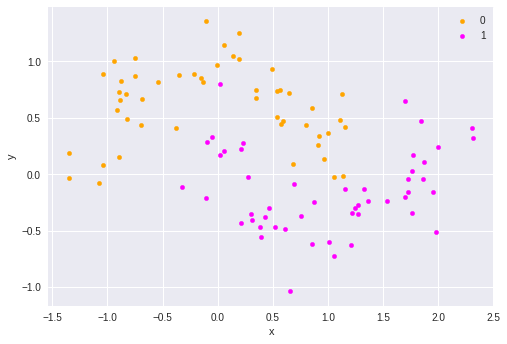

In [6]:
# İki sınıflı rastgele dağılımlı veri kümesi üretme (moons)
from sklearn.datasets import make_moons
from matplotlib import pyplot
from pandas import DataFrame
# veri setini 2 boyutlu düzlemde oluşurma, örnek sayısı, gürültü
X, y = make_moons(n_samples=100, noise=0.2, random_state=1)
# verilerin görselleştirilmesi
df = DataFrame(dict(x=X[:,0], y=X[:,1], label=y))
colors = {0:'orange', 1:'magenta'}
fig, ax = pyplot.subplots()
grouped = df.groupby('label')
for key, group in grouped:
    group.plot(ax=ax, kind='scatter', x='x', y='y', label=key, color=colors[key])
pyplot.show()

In [0]:
# Veri kümesini eğitim ve test olarak iki parçaya ayırma
n_train = 30
trainX, testX = X[:n_train, :], X[n_train:, :]
trainy, testy = y[:n_train], y[n_train:]

In [8]:
# Basit bir çok katmanlı sinir ağı (MLP) oluşturma
model = Sequential()
# 2 girişli 500 nöronlu gizli katman ve aktivasyon fonksiyonu ReLU
model.add(Dense(500, input_dim=2, activation='relu'))
# Çıkış katmanında tek nöron ve sigmoid fonksiyonu kullanılmaktadır
model.add(Dense(1, activation='sigmoid'))
# İkili çaprazentropi ile yitim değeri hesaplanıyor ve adam optimizasyonu ile hata minimize ediliyor. Başarım metriği olarak doğruluk kullanılıyor.
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

Instructions for updating:
Colocations handled automatically by placer.


**Oluşturulan sinir ağı modeli:** 2 girişli 500 nöronlu gizli katman ve aktivasyon fonksiyonu ReLU

[![image](https://i.hizliresim.com/oXm0zX.png)](https://hizliresim.com/oXm0zX)

In [9]:
# Modeli 4000 epoch için eğit
history = model.fit(trainX, trainy, validation_data=(testX, testy), epochs=4000, verbose=0)


Instructions for updating:
Use tf.cast instead.


In [10]:
# Modelin eğitim ve test başarımlarını hesapla ve ekrana yazdır.
_, train_acc = model.evaluate(trainX, trainy, verbose=0)
_, test_acc = model.evaluate(testX, testy, verbose=0)
print('Train: %.3f, Test: %.3f' % (train_acc, test_acc))

Train: 1.000, Test: 0.914


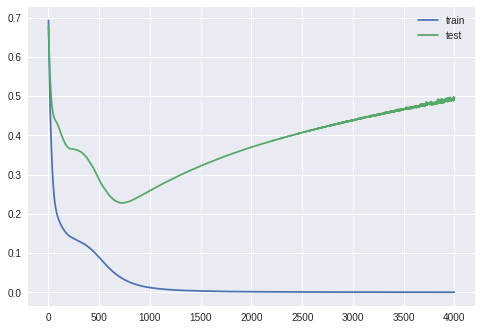

In [11]:
# Eğitim değerli history değişkeninde tutulmuştu tüm epochlar için bunu ekrana çizdirme işlemi
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

## Görünüyor ki ilk hatanın yükselmesi 200 civarındaki epoch ta bir de 750 civarlarındaki epochta gerçekleşiyor.

Bunun önünde geçme için erken durdurma işlemi yapmamız gerekiyor. İstersek 200lerdeki kırılmada durmasını sağlayabiliriz ama daha sonrabir miktar daha hata azaldığı için sonraki kırılmaya gelmesini de sağlayabiliriz. 

O halde devam!

[![image](https://i.hizliresim.com/16oV45.gif)](https://hizliresim.com/16oV45)


Epoch 00001: val_acc improved from -inf to 0.52857, saving model to best_model.h5

Epoch 00002: val_acc improved from 0.52857 to 0.62857, saving model to best_model.h5

Epoch 00003: val_acc improved from 0.62857 to 0.68571, saving model to best_model.h5

Epoch 00004: val_acc did not improve from 0.68571

Epoch 00005: val_acc did not improve from 0.68571

Epoch 00006: val_acc did not improve from 0.68571

Epoch 00007: val_acc did not improve from 0.68571

Epoch 00008: val_acc did not improve from 0.68571

Epoch 00009: val_acc did not improve from 0.68571

Epoch 00010: val_acc did not improve from 0.68571

Epoch 00011: val_acc improved from 0.68571 to 0.70000, saving model to best_model.h5

Epoch 00012: val_acc improved from 0.70000 to 0.71429, saving model to best_model.h5

Epoch 00013: val_acc did not improve from 0.71429

Epoch 00014: val_acc did not improve from 0.71429

Epoch 00015: val_acc did not improve from 0.71429

Epoch 00016: val_acc did not improve from 0.71429

Epoch 00017

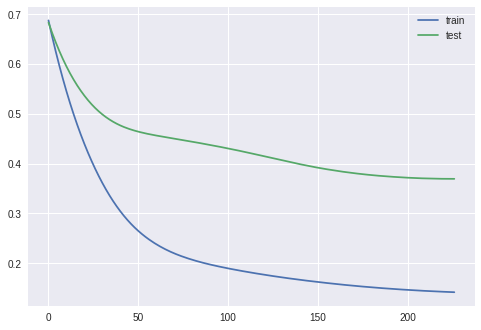

In [17]:
# MLP modelini tekrar oluştur ve bu kez içine erken durdurma adımını da ekle
from sklearn.datasets import make_moons
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import EarlyStopping
from matplotlib import pyplot
# 2 boyutta veri setini oluşturma
X, y = make_moons(n_samples=100, noise=0.2, random_state=1)
# veri setini parçalara ayırma
n_train = 30
trainX, testX = X[:n_train, :], X[n_train:, :]
trainy, testy = y[:n_train], y[n_train:]
# Modeli tanımlama
model = Sequential()
model.add(Dense(500, input_dim=2, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])


# BASİT BİR ERKEN DURDURMA İŞLEMİ
es = EarlyStopping(monitor='val_loss', mode='auto', verbose=1)
# ERKEN DURDURMA SONUCU EN İYİ BAŞARIMIN MODEL BAŞARIMI OLARAK KAYDEDİLMESİ
mc = ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)
# Modeli erken durdurma ve en iyi başarımı kaydetme callback parametrelerini ekleyerek tekrar eğitme
history = model.fit(trainX, trainy, validation_data=(testX, testy), epochs=4000, verbose=0, callbacks=[es, mc])
# Test ve Eğitim başarılarının hesaplanması
_, train_acc = model.evaluate(trainX, trainy, verbose=0)
_, test_acc = model.evaluate(testX, testy, verbose=0)
print('Train: %.3f, Test: %.3f' % (train_acc, test_acc))
# Eğitim ve test sonuçlarının ekrana yazılması ve çizdirilmesi
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()


**ModelCheckpoint** fonksiyonunu kullanarak **erken durduma** ile birlikte modeli tekrar eğit ve en iyi model ağırlıklarını **best_model.h5** dosyasına kaydet.

### Modelimizin başarımını artırmak için bir küçük ayrıntıyı daha öğrendik :) 

![image](https://1.bp.blogspot.com/-N3AonYUI5lg/WpY8lQoFHdI/AAAAAAAAANo/AMxkSfGGB8QK5evTbu-jewH2ZuPmQMnIQCLcBGAs/s1600/giphy-downsized-large.gif)